# Imports and Helper Functions

In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import random
import os
from torchvision import datasets, transforms
import datetime
from tqdm.auto import tqdm

In [2]:
from typing import Any

_batch_sizes = {
    "resnet18": 64,
    "resnet34": 64,
    "resnet50": 32,
    "resnet101": 16,
}

class Config:
    seed = 42
    lr = 0.001
    epochs = 20
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = "resnet18" # resnet18, resnet34, resnet50, resnet101, resnet152
    batch_size = _batch_sizes[model]
    suffix = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    save_dir = f"checkpoints/{model}-{suffix}"


In [3]:
# Grayscale to RGB transform
class GrayscaleToRGB(object):
    """From https://www.kaggle.com/code/cafalena/caltech101-pytorch-deep-learning"""
    def __call__(self, img):
        if img.mode == 'L':
            img = img.convert("RGB")
        return img

transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    GrayscaleToRGB(),]
    )

tranform_preprocess = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])]
    )

# Load Caltech101 dataset
def load_data():
    dataset = datasets.Caltech101(root='caltech_data', download=False, transform=transform)

    return dataset

# Split dataset into training and testing
def split_data(dataset):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(Config.seed))
    return train_dataset, test_dataset

# Load pretrained ResNet model
def load_model(model_name: str):
    model = getattr(models, model_name)(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 101)
    return model

def get_model_predictor(model):
    def predictor(image):
        model.eval()
        with torch.no_grad():
            image = torch.stack([tranform_preprocess(img) for img in image], dim=0)
            image = image.to(Config.device)
            output = model(image)
            output = F.softmax(output, dim=1)
            return output.detach().cpu().numpy()
        
    return predictor

# Load Data and model

In [4]:
dataset = load_data()
train_dataset, test_dataset = split_data(dataset)

In [5]:
model_checkpoints = os.listdir("checkpoints")
model_checkpoints = {
    'resnet18': [f for f in model_checkpoints if 'resnet18' in f],
    'resnet34': [f for f in model_checkpoints if 'resnet34' in f],
    'resnet50': [f for f in model_checkpoints if 'resnet50' in f],
    'resnet101': [f for f in model_checkpoints if 'resnet101' in f],
}

# Load model
MODEL = 'resnet18'
model = load_model(MODEL).to('cuda')
if model_checkpoints[MODEL]:
    model.load_state_dict(torch.load(f"checkpoints/{model_checkpoints[MODEL][0]}/model.pth"))
    print(f"Loaded model from {model_checkpoints[MODEL][0]}")
else:
    print("No model checkpoint found, loading pretrained model")

model = model.eval()

/home/suyog/anaconda3/envs/cellstory/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suyog/anaconda3/envs/cellstory/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model from resnet18-20240917-161535


# 1. LIME Explainer

In [6]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2

def explain(model, image, top_labels=3, hide_color=0, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np.array(image),
        get_model_predictor(model),
        top_labels=top_labels,
        hide_color=hide_color,
        num_samples=num_samples
    )
    return explanation

# Visualization
def get_temp_mask(explanation, label_idx):
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[label_idx],
        positive_only=False,
        num_features=3,
        hide_rest=False
    )
    return temp, mask


In [7]:
# Create output directory
os.makedirs(f"outputs/lime/{MODEL}/good", exist_ok=True)
os.makedirs(f"outputs/lime/{MODEL}/bad", exist_ok=True)

# Get explanation for all images and save
for idx in tqdm(range(len(test_dataset))):
    if os.path.exists(f"outputs/lime/{MODEL}/good/{idx}.png") or os.path.exists(f"outputs/lime/{MODEL}/bad/{idx}.png"):
        continue
    image, label = test_dataset[idx]
    explanation = explain(model, image, top_labels=3, hide_color=0, num_samples=100)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle("LIME Explanation for top 3 labels")
    for i in range(3):
        temp, mask = get_temp_mask(explanation, i)
        axes[i].imshow(mark_boundaries(temp, mask))
        axes[i].axis("off")
        axes[i].set_title(f"Label: {dataset.categories[explanation.top_labels[i]]}")
    
    if label == explanation.top_labels[0]:
        plt.savefig(f"outputs/lime/{MODEL}/good/{idx}.png")
    else:
        plt.savefig(f"outputs/lime/{MODEL}/bad/{idx}.png")
    plt.close()


  0%|          | 0/1736 [00:00<?, ?it/s]

# GradCAM

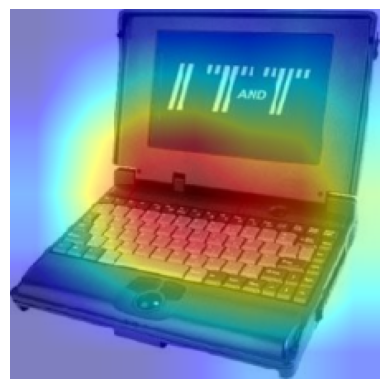

In [8]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

target_layers = [model.layer4[-1]]

idx = random.randint(0, len(test_dataset))
input_tensor = tranform_preprocess(test_dataset[idx][0]).unsqueeze(0).to(Config.device)
label = test_dataset[idx][1]
rgb_img = np.array(test_dataset[idx][0]) / 255.0
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(label)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

plt.imshow(visualization); plt.axis('off'); plt.show()

In [ ]:
# Save top-5 labels for each image in test dataset
top5_labels = []
gt_labels = []

for idx in tqdm(range(len(test_dataset))):
    image, label = test_dataset[idx]
    input_tensor = tranform_preprocess(image).unsqueeze(0).to(Config.device)
    gt_labels.append(label)

    # Get top-5 labels
    outputs = model(input_tensor)
    _, top5 = torch.topk(outputs, 5)
    top5_labels.append(top5.cpu().numpy()[0])
    


In [10]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

# For ResNet, the last layer is model.layer4[-1]
target_layers = [model.layer4[-1]]
top_k = 3

# Save directory
os.makedirs(f"outputs/gradcam/{MODEL}/good", exist_ok=True)
os.makedirs(f"outputs/gradcam/{MODEL}/bad", exist_ok=True)
os.makedirs(f"outputs/ablationcam/{MODEL}/good", exist_ok=True)
os.makedirs(f"outputs/ablationcam/{MODEL}/bad", exist_ok=True)

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
    with AblationCAM(model=model, target_layers=target_layers) as ablation_cam:
        for idx in tqdm(range(300)):
        # for idx in tqdm([1437]):
            # if os.path.exists(f"outputs/gradcam/{MODEL}/{'good' if gt_label == top5_labels[idx][0] else 'bad'}/{idx}.png") or os.path.exists(f"outputs/ablationcam/{MODEL}/{'good' if gt_label == top5_labels[idx][0] else 'bad'}/{idx}.png"):
            #     continue
            
            input_tensor = tranform_preprocess(test_dataset[idx][0]).unsqueeze(0).to(Config.device)
            gt_label = test_dataset[idx][1]
            rgb_img = np.array(test_dataset[idx][0]) / 255.0
            input_tensor = torch.stack([input_tensor[0]]*top_k, dim=0)
            targets = [ClassifierOutputTarget(l) for l in top5_labels[idx][:top_k]]

            # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            visualizations = [
                show_cam_on_image(rgb_img, cam, use_rgb=True)
                for cam in grayscale_cam
            ]

            ablation_cams = ablation_cam(input_tensor=input_tensor, targets=targets)
            visualizations_ablation = [
                show_cam_on_image(rgb_img, cam, use_rgb=True)
                for cam in ablation_cams
            ]
            # You can also get the model outputs without having to redo inference
            # model_outputs = cam.outputs

            # plt.imshow(visualization); plt.axis('off'); plt.show()
            fig, axes = plt.subplots(1, top_k, figsize=(3*top_k, 3))
            fig.suptitle(f"GradCAM for top {top_k} labels")
            for i, visualization in enumerate(visualizations):
                axes[i].imshow(visualization)
                axes[i].axis("off")
                axes[i].set_title(f"Label: {dataset.categories[top5_labels[idx][i]]}")
            plt.savefig(f"outputs/gradcam/{MODEL}/{'good' if gt_label == top5_labels[idx][0] else 'bad'}/{idx}.png")
            plt.close()

            fig, axes = plt.subplots(1, top_k, figsize=(3*top_k, 3))
            fig.suptitle(f"AblationCAM for top {top_k} labels")
            for i, visualization in enumerate(visualizations_ablation):
                axes[i].imshow(visualization)
                axes[i].axis("off")
                axes[i].set_title(f"Label: {dataset.categories[top5_labels[idx][i]]}")
            plt.savefig(f"outputs/ablationcam/{MODEL}/{'good' if gt_label == top5_labels[idx][0] else 'bad'}/{idx}.png")
            plt.close()

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 143.47it/s]


# Figures

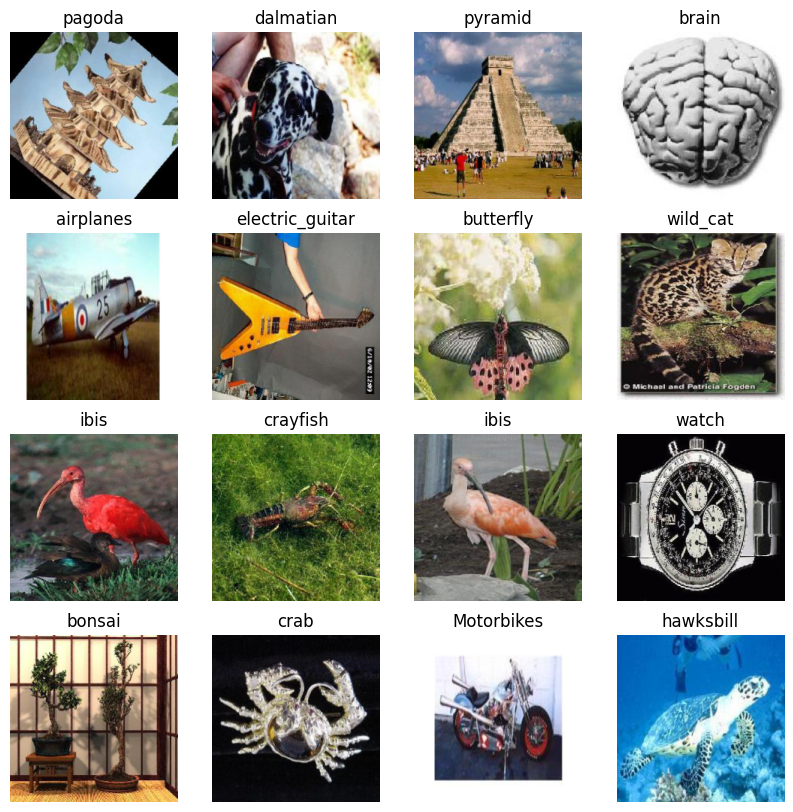

In [20]:
# A grid showing a sample of images from the dataset with their corresponding labels.
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
test_dataset.transform = None
random_sample = random.sample(range(len(test_dataset)), 16)
for i in range(4):
    for j in range(4):
        img, label = test_dataset[random_sample[i*4+j]]
        ax[i, j].imshow(img)
        ax[i, j].set_title(dataset.categories[label])
        ax[i, j].axis("off")
plt.show()

